# Policies aproximation stats

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from environment import Environment

# Set device
print(sys.version)
print(torch.__version__)
print(torch.version.cuda)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

3.9.5 (default, May 11 2021, 08:20:37) 
[GCC 10.3.0]
1.9.1+cu111
11.1
cuda


## Load environment and list of valid states

In [2]:
sel_env = 4
res = 2

MAP = np.loadtxt('Env'+str(sel_env)+'_res'+str(res)+'.txt', skiprows=1, dtype = int)
WIDTH = MAP.shape[0]
LENGTH = MAP.shape[1]

E = np.loadtxt('E_Env'+str(sel_env)+'_res'+str(res)+'.txt')
W = np.loadtxt('W_Env'+str(sel_env)+'_res'+str(res)+'.txt').tolist()

# Replace inf values in E for the second largest value plus 1
E[E == np.inf] = -1
E[E == -1] = np.max(E) + 1
E = E.astype(np.int64)
max_diff = 10

# Environmnet
env_head = [WIDTH, LENGTH, sel_env, res]
print(env_head)
env = Environment(env_head, device)

states_actions = pd.read_csv('./train_set_Env'+str(sel_env)+'_res'+str(res)+'.csv', dtype=np.float32)
states_actions = states_actions.drop(np.where(np.array(states_actions) == -1.)[0])                         # Only states where initial visibility are considered
states_actions = states_actions.sample(frac = 1).reset_index(drop = True)

states = np.delete(states_actions.to_numpy(), np.s_[4:7], axis=1 )

[30, 30, 4, 2]


## Load trained models

In [3]:
from models import evader_NN
evader_model = torch.load('evader_NN_Env' + str(sel_env) + '_res' + str(res) + '.pt', map_location=torch.device(device)).to(device)
evader_model.eval().to(device = device)

evader_NN(
  (predict): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=4, bias=True)
    (9): Softmax(dim=-1)
  )
)

In [4]:
from models import pursuer_NN
pursuer_model = torch.load('pursuer_NN_Env' + str(sel_env) + '_res' + str(res) + '.pt', map_location=torch.device(device))
pursuer_model.eval().to(device = device)

pursuer_NN(
  (predict): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=5, bias=True)
    (9): Softmax(dim=-1)
  )
)

In [5]:
# Find the valid neighbors of a given point (x) in W
def neighborhood(x):
    neighbors = []
    x1 = x + np.array([1, 0])
    x2 = x + np.array([0, 1])
    x3 = x + np.array([-1, 0])
    x4 = x + np.array([0, -1])

    all_x = [x1,x2,x3,x4]

    for x_i in all_x:
        if 0 <= x_i[1] < LENGTH and 0 <= x_i[0] < WIDTH:
            if x_i.tolist() in W: neighbors.append(x_i)
    return neighbors


# Get value in table E for given evader and pursuer positions
def getValue_E(e,p):
    return E[W.index(e.tolist())][W.index(p.tolist())]

def which_action_pursuer(diff):
    if (diff == np.array([0, 0])).all():
        return 0
    elif (diff == np.array([0, 1])).all():
        return 1
    elif (diff == np.array([-1, 0])).all():
        return 2
    elif (diff == np.array([0,-1])).all():
        return 3
    elif (diff == np.array([1, 0])).all():
        return 4

def which_action_evader(diff):
    if (diff == np.array([0, 1])).all():
        return 0
    elif (diff == np.array([-1, 0])).all():
        return 1
    elif (diff == np.array([0,-1])).all():
        return 2
    elif (diff == np.array([1, 0])).all():
        return 3

from sympy import Polygon
from obstacles import obstacles_per_env
Obs = obstacles_per_env(sel_env)

def isVisual(s):
        x = s[0:2]
        y = s[2:4]
        for obstacle in Obs:
            if len(obstacle.intersection(Polygon(x,y))) > 1 or obstacle.encloses_point(x) or obstacle.encloses_point(y):
                return False
        return True


## Get sample of random initial states for evaluation

The sample size is get according to the formula:
$$
    m = \frac{NZ_{\alpha}^2pq}{e^2(N-1) + Z_{\alpha}^2pq}
$$

where:
* $N$ is the total of states where there exists initial visibility
* $Z_{\alpha}^2 = 1.96$ is the trust level
* $e = 0.05$ is the estimation error accepted
* $p=0.5$
* $q=0.5$

In [6]:
from copy import copy
N = states.shape[0]
Z = 1.96
e = 0.05
p = 0.5
q = 0.5

m = np.ceil((N*Z**2 * p * q) / (e**2 * (N-1) + Z**2 * p * q)).astype(int)
states_sample = states[:m,:]
states_sample_p = copy(states_sample)
max_steps = np.max(E)

print(m, 'initial states are considered out of', N, 'as total')

escape_lens = []

for state in states_sample:
    s = (state * res).astype(np.int64)
    e = s[0:2]
    p = s[2:4]

    # Reference of escape length, the one computed by dynamic programming
    escape_length = getValue_E(e,p)

    escape_lens.append(escape_length)


#np.savetxt('states.txt', states_sample, delimiter=' ')
#np.savetxt('E_values.txt', escape_lens, delimiter=' ')

382 initial states are considered out of 55994 as total


## Compare evader and pursuer Neural networks performance

In [7]:
env = Environment(env_head, device)
escape_diff = []
confussion_matrix = np.zeros((2,2), dtype=np.int64)

# Game loop
for i in range(m):
    state = states_sample[i]
    env.state = state
    steps = 1
    while steps <= max_steps:
        evader_dist = evader_model(state).detach().cpu().numpy()
        state, _, _, _ = env.step_evader_best_action(evader_dist)

        pursuer_dist = pursuer_model(state).detach().cpu().numpy()
        state, _, done, _ = env.step_pursuer_best_action(pursuer_dist)

        if done:
            break

        steps += 1
        state = env.state

    # Matriz de confusion
    if escape_lens[i] < max_steps:
        if steps < max_steps:
            confussion_matrix[0][0] += 1
        else:
            confussion_matrix[0][1] += 1
    else:
        if steps < max_steps:
            confussion_matrix[1][0] += 1
        else:
            confussion_matrix[1][1] += 1

    val = steps - escape_lens[i]
    if val > 10: val = 10
    escape_diff.append(val)

    if i % 10 == 0 or i == m-1:
        print('\rState {} out of {}'.format(i+1, m), end='')
        #print('State', i+1,'out of', m)

print('\n', confussion_matrix)

State 382 out of 382
 [[291   3]
 [ 60  28]]


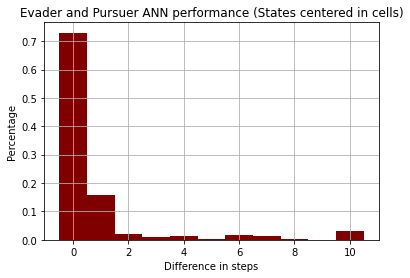

[0.72961373 0.15879828 0.02145923 0.00858369 0.01287554 0.00429185
 0.01716738 0.01287554 0.00429185 0.         0.03004292]


In [8]:
percentage, _, _ = plt.hist(escape_diff, bins=np.linspace(0,11,12) , facecolor='maroon', density=True, align='left')
plt.title('Evader and Pursuer ANN performance (States centered in cells)')
plt.ylabel('Percentage')
plt.xlabel('Difference in steps')
plt.grid(True)
plt.savefig('Env'+str(sel_env)+'_res'+str(res)+'NNeval.png')
plt.show()

print(percentage)

## Compare evader and pursuer Neural networks performance with perturbed initial positions

In [9]:
env = Environment(env_head, device)
sigma = 1/(4*res)       # To be used adding noise to the states
states_disturbed = states_sample + np.random.normal(loc=0., scale=sigma, size=states_sample.shape)

confussion_matrix_disturbed = np.zeros((2,2), dtype=np.int64)

escape_diff_disturbed = []
# Game loop
for i in range(m):
    state = states_disturbed[i]
    env.state = state
    steps = 1
    while steps <= max_steps:
        evader_dist = evader_model(state).detach().cpu().numpy()
        state, _, _, _ = env.step_evader_best_action(evader_dist)

        pursuer_dist = pursuer_model(state).detach().cpu().numpy()
        state, _, done, _ = env.step_pursuer_best_action(pursuer_dist)

        if done:
            break

        steps += 1
        state = env.state

    # Matriz de confusion
    if escape_lens[i] < max_steps:
        if steps < max_steps:
            confussion_matrix_disturbed[0][0] += 1
        else:
            confussion_matrix_disturbed[0][1] += 1
    else:
        if steps < max_steps:
            confussion_matrix_disturbed[1][0] += 1
        else:
            confussion_matrix_disturbed[1][1] += 1

    val = steps - escape_lens[i]
    if val > 10: val = 10
    escape_diff_disturbed.append(val)

    if i % 10 == 0 or i == m-1:
        print('\rState {} out of {}'.format(i+1, m), end='')
        if i == m-1:
            print('\n')

#np.savetxt('states_disturbed.txt', states_disturbed, delimiter=' ')
print(confussion_matrix_disturbed)

State 382 out of 382

[[283  11]
 [ 52  36]]


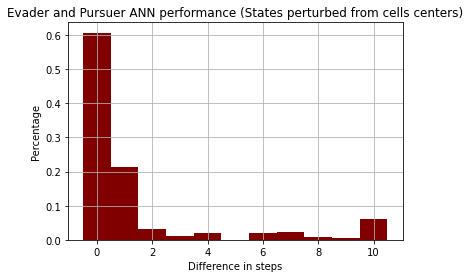

[0.60714286 0.21428571 0.03174603 0.01190476 0.01984127 0.
 0.01984127 0.02380952 0.00793651 0.00396825 0.05952381]


In [10]:
percentage, _, _ = plt.hist(escape_diff_disturbed, bins=np.linspace(0,11,12), facecolor='maroon', density=True, align='left')
plt.title('Evader and Pursuer ANN performance (States perturbed from cells centers)')
plt.ylabel('Percentage')
plt.xlabel('Difference in steps')
plt.grid(True)
plt.savefig('Env'+str(sel_env)+'_res'+str(res)+'NNeval_disturbed.png')
plt.show()

print(percentage)

## Compare Evader trained network to Pursuer optimal planning

In [11]:
env = Environment(env_head, device)
escape_diff_evader = []
confussion_matrix_evader = np.zeros((2,2), dtype=np.int64)

# Game loop
for i in range(m):
    state = states_sample[i]
    steps = 1

    env.state = state

    while steps <= max_steps:
        evader_dist = evader_model(state).detach().cpu().numpy()
        state, _, _, _ = env.step_evader_best_action(evader_dist)

        s = (state * res).astype(np.int64)
        e = s[0:2]
        p = s[2:4]

        # Pursuer moves with optimal planning
        N_p = neighborhood(p)
        if escape_lens[i] == max_steps:
            if getValue_E(e, p) != max_steps:
                for p_prime in N_p:
                    if getValue_E(e, p_prime) == max_steps:
                        p = p_prime
                        break
        else:
            S = []
            max_val = getValue_E(e, p)
            for p_prime in N_p:
                max_val = max(max_val, getValue_E(e, p_prime))
            if getValue_E(e, p) == max_val:
                S.append(p)
            for p_prime in N_p:
                if getValue_E(e, p_prime) == max_val:
                    S.append(p_prime)
            
            dist_to_max = []
            for s in S:
                dist_to_max.append(np.linalg.norm(e - s))
            p = S[np.argmin(dist_to_max)]

        p = (p + 0.5)/res
        state[2:4] = p

        env.state = state

        if not isVisual(state):
            break
           
        steps += 1

    # Matriz de confusion
    if escape_lens[i] < max_steps:
        if steps < max_steps:
            confussion_matrix_evader[0][0] += 1
        else:
            confussion_matrix_evader[0][1] += 1
    else:
        if steps < max_steps:
            confussion_matrix_evader[1][0] += 1
        else:
            confussion_matrix_evader[1][1] += 1


    val = steps - escape_lens[i]
    if val > 10: val = 10
    escape_diff_evader.append(val)

    if i % 10 == 0 or i == m-1:
        print('\rState {} out of {}'.format(i+1, m), end='')
        if i == m-1:
            print('\n')

print(confussion_matrix_evader)

State 382 out of 382

[[288   6]
 [  0  88]]


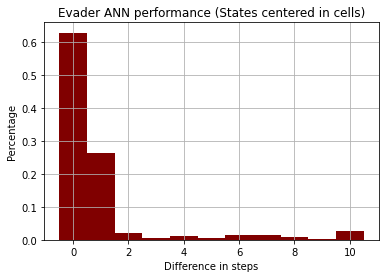

[0.62827225 0.26439791 0.02094241 0.0052356  0.0104712  0.0052356
 0.01308901 0.01570681 0.0078534  0.0026178  0.02617801]


In [12]:
percentage, _, _ = plt.hist(escape_diff_evader, bins=np.linspace(0,11,12) , facecolor='maroon', density=True, align='left')
plt.title('Evader ANN performance (States centered in cells)')
plt.ylabel('Percentage')
plt.xlabel('Difference in steps')
plt.grid(True)
plt.savefig('Env'+str(sel_env)+'_res'+str(res)+'NNeval_evader.png')
plt.show()

print(percentage)

## Compare Pursuer trained network to Evader optimal planning

In [13]:
env = Environment(env_head, device)
escape_diff_pursuer = []
confussion_matrix_pursuer = np.zeros((2,2), dtype=np.int64)

# Game loop
for i in range(m):
    state = states_sample[i]
    steps = 1

    s = (state * res).astype(np.int64)
    e_last = s[0:2]
    while steps <= max_steps:
        s = (state * res).astype(np.int64)
        e = s[0:2]
        p = s[2:4]

        # Evader moves with optimal planning
        N_e = neighborhood(e)
        N_p = neighborhood(p)
        if escape_lens[i] == max_steps:
            valE_in_Ne = []
            for e_prime in N_e:
                if (e_prime == e_last).all():
                    valE_in_Ne.append(np.inf)
                else:
                    valE_in_Ne.append(getValue_E(e_prime, p))
            e_last = e

            min_valE = np.argwhere(valE_in_Ne == np.min(valE_in_Ne))
            if min_valE.shape[0] * min_valE.shape[1] == 1:
                e = N_e[min_valE[0][0]]
            else:
                dist_to_pursuer = []
                for m_i in min_valE:
                    dist_to_pursuer.append(np.linalg.norm(N_e[m_i[0]] - p))
                e = N_e[min_valE[np.argmax(dist_to_pursuer)][0]]
        else:
            maxes = []
            for e_prime in N_e:
                max_val = getValue_E(e_prime, p)
                for p_prime in N_p:
                    max_val = max(max_val, getValue_E(e_prime, p_prime))
                maxes.append(max_val)
            e = N_e[np.argmin(maxes)]

        e = (e + 0.5)/res
        state[0:2] = e
        
        env.state = state

        pursuer_dist = pursuer_model(state).detach().cpu().numpy()
        state, _, done, _ = env.step_pursuer_best_action(pursuer_dist)

        if done:
            break

        steps += 1

    # Matriz de confusion
    if escape_lens[i] < max_steps:
        if steps < max_steps:
            confussion_matrix_pursuer[0][0] += 1
        else:
            confussion_matrix_pursuer[0][1] += 1
    else:
        if steps < max_steps:
            confussion_matrix_pursuer[1][0] += 1
        else:
            confussion_matrix_pursuer[1][1] += 1


    val = steps - escape_lens[i]
    if val > 10: val = 10
    escape_diff_pursuer.append(val)

    if i % 10 == 0 or i == m-1:
        print('\rState {} out of {}'.format(i+1, m), end='')
        if i == m-1:
            print('\n')

print(confussion_matrix_pursuer)

State 382 out of 382

[[294   0]
 [ 69  19]]


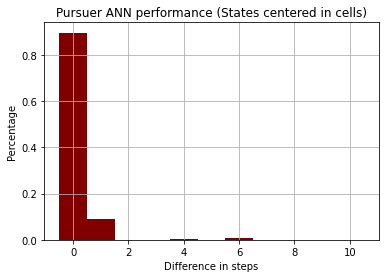

[0.89732143 0.08928571 0.         0.         0.00446429 0.
 0.00892857 0.         0.         0.         0.        ]


In [14]:
percentage, _, _ = plt.hist(escape_diff_pursuer, bins=np.linspace(0,11,12) , facecolor='maroon', density=True, align='left')
plt.title('Pursuer ANN performance (States centered in cells)')
plt.ylabel('Percentage')
plt.xlabel('Difference in steps')
plt.grid(True)
plt.savefig('Env'+str(sel_env)+'_res'+str(res)+'NNeval_pursuer.png')
plt.show()

print(percentage)

In [15]:
conffusion_matrices = np.array([confussion_matrix, confussion_matrix_disturbed, confussion_matrix_evader, confussion_matrix_pursuer],dtype=np.int64).transpose(1,0,2).reshape(2,-1)
np.savetxt('Env'+str(sel_env)+'_res'+str(res)+'_conf_matrices.txt', conffusion_matrices,fmt='%d')